### Etymology Prefix Suffix Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import re
from kneed import KneeLocator
from pathlib import Path
import shutil

In [2]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
lang_pair = "French"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# pre-suffix select
prefix = True  # True, False  word is prefix  example: prefix = True and suffix = False for Turkish word
suffix = False # True, False  word is suffix

# native word select
word_analysis = False  # True, False  Not: True for native word analysis, False for etymological word analysis
word_num = 28

In [3]:
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}").mkdir(parents=True, exist_ok=True)
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}").mkdir(parents=True, exist_ok=True)

In [4]:
def detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False):
    '''
    default parameter:\n
    detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False)\n
    detect_prefix_suffix_word(df, "word", ["abacus","aba","su"], prefix=True, suffix=True)\n
    df is dataframe. Each word of word_ety_list search in df_column according to prefix_word and suffix_word condition.\n
    prefix_word and suffix_word are not extention. they represents location of word of word_ety_list (word before or after)
    '''    
    df_ety_prefix_suffix_word_result = pd.DataFrame()
    for i in word_ety_list:
        # suffix result
        if suffix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"{i}(?:$)", na=True)]  # string+ext=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass
        # prefix result
        if prefix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"(?:^){i}", na=True)]  # ext+string=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass    
        
    #df_ety_suffix_word_result = df_word_result.sort_values(by="frequency", ascending=False)
    df_ety_prefix_suffix_word_result.drop_duplicates(inplace=True)
    df_ety_prefix_suffix_word_result.reset_index(drop=True, inplace=True)

    return df_ety_prefix_suffix_word_result 

In [5]:
def exract_prefix_suffix(df, source_column, target_column):
    '''
    exract_prefix_suffix(df, source_column, target_column):\n
    exract_prefix_suffix(df, "word_pair", "word"):\n
    df is dataframe. word of source_column search in target_column\n
    and exract prefix or suffix. 
    '''
    for i in range(len(df)):
        source_word = df.loc[i,f"{source_column}"]
        target_word = df.loc[i,f"{target_column}"]
        try:
            search_loc = re.search(fr"{source_word}", target_word, re.UNICODE|re.IGNORECASE)
            search_loc_start = search_loc.span()[0]
            search_loc_end = search_loc.span()[1]
            if search_loc_start > 0:
                var1= target_word[0:search_loc_start]
                prefix_suffix = f"{var1}+"
                df.loc[i,"prefix_suffix"] = prefix_suffix                
            else:
                var2 = target_word[search_loc_end:]
                prefix_suffix = f"+{var2}" 
                df.loc[i,"prefix_suffix"] = prefix_suffix 
        except:
            pass
    return df

##### Prefix Suffix All

In [6]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

,word,frequency
0,bir,18835735
1,bu,11062659
2,ne,8025880
3,ve,7766036
4,için,5484109
...,...,...
989326,karneleme,5
989327,karnaya,5
989328,dörtlümüzün,5
989329,karnavalınız,5


In [10]:
if word_analysis:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
    df_pair = df_pair.head(word_num)
    df_pair.rename(columns={"word":"dict_entry_main"}, inplace=True)
else:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}/{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Vocabulary.xlsx")
df_pair

,dict_entry_main,french_word
0,madalya,médaille
1,banka,banque
2,viski,whisky
3,sandviç,sandwich
4,futbol,football
...,...,...
4277,illüzyon,illusion
4278,asteroid,asteroïde
4279,fenomen,phénomene
4280,banliyö,banlieu


In [11]:
word_ety_list = df_pair["dict_entry_main"].values.tolist()
#word_ety_list

In [12]:
df_prefix_suffix_word = detect_prefix_suffix_word(df_word_all, "word", word_ety_list, prefix_word=prefix, suffix_word=suffix)
df_prefix_suffix_word

,search_word,word,frequency
0,madalya,madalya,8021
1,madalya,madalyası,3636
2,madalya,madalyayı,1645
3,madalya,madalyasını,891
4,madalya,madalyalı,660
...,...,...,...
163220,asteroid,asteroidden,14
163221,asteroid,asteroidlerden,8
163222,asteroid,asteroidte,6
163223,asteroid,asteroidinin,6


In [13]:
df_prefix_suffix = exract_prefix_suffix(df_prefix_suffix_word, "search_word", "word")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,madalya,madalya,8021,+
1,madalya,madalyası,3636,+sı
2,madalya,madalyayı,1645,+yı
3,madalya,madalyasını,891,+sını
4,madalya,madalyalı,660,+lı
...,...,...,...,...
163220,asteroid,asteroidden,14,+den
163221,asteroid,asteroidlerden,8,+lerden
163222,asteroid,asteroidte,6,+te
163223,asteroid,asteroidinin,6,+inin


In [14]:
df_prefix_suffix.search_word.nunique()

3437

In [15]:
df_prefix_suffix.word.nunique()

143808

In [16]:
if word_analysis:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_All.xlsx", index=False)
else:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx", index=False)

##### Select From Length

In [17]:
if word_analysis:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_All.xlsx")
else:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,madalya,madalya,8021,+
1,madalya,madalyası,3636,+sı
2,madalya,madalyayı,1645,+yı
3,madalya,madalyasını,891,+sını
4,madalya,madalyalı,660,+lı
...,...,...,...,...
163220,asteroid,asteroidden,14,+den
163221,asteroid,asteroidlerden,8,+lerden
163222,asteroid,asteroidte,6,+te
163223,asteroid,asteroidinin,6,+inin


In [18]:
df_prefix_suffix["prefix_suffix_len"] = df_prefix_suffix["prefix_suffix"].apply(lambda x: (len(x)-1))
df_prefix_suffix

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,madalya,madalya,8021,+,0
1,madalya,madalyası,3636,+sı,2
2,madalya,madalyayı,1645,+yı,2
3,madalya,madalyasını,891,+sını,4
4,madalya,madalyalı,660,+lı,2
...,...,...,...,...,...
163220,asteroid,asteroidden,14,+den,3
163221,asteroid,asteroidlerden,8,+lerden,6
163222,asteroid,asteroidte,6,+te,2
163223,asteroid,asteroidinin,6,+inin,4


In [19]:
prefix_suffix_mean = int(round(df_prefix_suffix["prefix_suffix_len"].mean(),0))
prefix_suffix_mean

6

In [20]:
df_prefix_suffix_select = df_prefix_suffix[df_prefix_suffix["prefix_suffix"].str.len() <= prefix_suffix_mean]
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,madalya,madalya,8021,+,0
1,madalya,madalyası,3636,+sı,2
2,madalya,madalyayı,1645,+yı,2
3,madalya,madalyasını,891,+sını,4
4,madalya,madalyalı,660,+lı,2
...,...,...,...,...,...
163219,asteroid,asteroidlerin,25,+lerin,5
163220,asteroid,asteroidden,14,+den,3
163222,asteroid,asteroidte,6,+te,2
163223,asteroid,asteroidinin,6,+inin,4


In [21]:
if word_analysis:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Select.xlsx", index=False)
else:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx", index=False)

##### Select With Prefix Suffix

In [22]:
if word_analysis:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Select.xlsx")
else:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx")
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,madalya,madalya,8021,+,0
1,madalya,madalyası,3636,+sı,2
2,madalya,madalyayı,1645,+yı,2
3,madalya,madalyasını,891,+sını,4
4,madalya,madalyalı,660,+lı,2
...,...,...,...,...,...
82864,asteroid,asteroidlerin,25,+lerin,5
82865,asteroid,asteroidden,14,+den,3
82866,asteroid,asteroidte,6,+te,2
82867,asteroid,asteroidinin,6,+inin,4


In [23]:
df_prefix_suffix_freq = df_prefix_suffix_select[["prefix_suffix"]].value_counts().reset_index()
df_prefix_suffix_freq.rename(columns={0:"frequency"}, inplace=True)
df_prefix_suffix_freq

,prefix_suffix,frequency
0,+,3251
1,+ler,838
2,+i,815
3,+a,811
4,+e,805
...,...,...
16704,+misi,1
16705,+misil,1
16706,+dyum,1
16707,+miss,1


In [24]:
prefix_suffix_freq_sum = df_prefix_suffix_freq.loc[:,"frequency"].sum()
prefix_suffix_freq_sum

82869

In [25]:
df_prefix_suffix_freq["ratio"] = round(((df_prefix_suffix_freq.loc[:,"frequency"]/prefix_suffix_freq_sum)*100),7)
df_prefix_suffix_freq


,prefix_suffix,frequency,ratio
0,+,3251,3.923059
1,+ler,838,1.011235
2,+i,815,0.983480
3,+a,811,0.978653
4,+e,805,0.971413
...,...,...,...
16704,+misi,1,0.001207
16705,+misil,1,0.001207
16706,+dyum,1,0.001207
16707,+miss,1,0.001207


In [26]:
df_prefix_suffix_freq["cumul_ratio"] = np.cumsum(df_prefix_suffix_freq["ratio"])
df_prefix_suffix_freq

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,3251,3.923059,3.923059
1,+ler,838,1.011235,4.934294
2,+i,815,0.983480,5.917774
3,+a,811,0.978653,6.896427
4,+e,805,0.971413,7.867840
...,...,...,...,...
16704,+misi,1,0.001207,99.994817
16705,+misil,1,0.001207,99.996024
16706,+dyum,1,0.001207,99.997231
16707,+miss,1,0.001207,99.998437


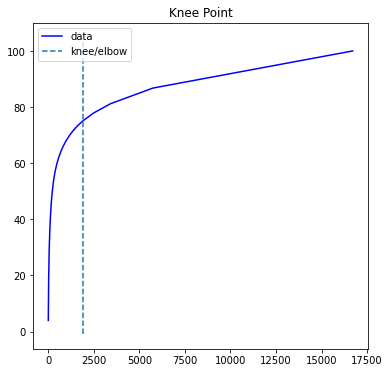

In [27]:
prefix_suffix_kneedle = KneeLocator(x=df_prefix_suffix_freq.cumul_ratio.index, y=df_prefix_suffix_freq.cumul_ratio, S=1.0, curve="concave", direction="increasing")
prefix_suffix_kneedle.plot_knee()

In [28]:
knee_point_prefix_suffix = round(prefix_suffix_kneedle.knee_y)
knee_point_prefix_suffix

75

In [29]:
df_prefix_suffix_knee = df_prefix_suffix_freq[df_prefix_suffix_freq.cumul_ratio <= knee_point_prefix_suffix]
df_prefix_suffix_knee

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,3251,3.923059,3.923059
1,+ler,838,1.011235,4.934294
2,+i,815,0.983480,5.917774
3,+a,811,0.978653,6.896427
4,+e,805,0.971413,7.867840
...,...,...,...,...
1876,+lene,5,0.006034,74.973743
1877,+loya,5,0.006034,74.979776
1878,+inoya,5,0.006034,74.985810
1879,+yyle,5,0.006034,74.991843


In [30]:
prefix_suffix_list = df_prefix_suffix_knee["prefix_suffix"].to_list()

In [31]:
disable_prefix_suffix_list = ["+anityi","+bidir","+workun","+düktörlere","+rysin","+ein","+ei","+x","+ren","+hul"]

In [32]:
set_prefix_suffix = set(prefix_suffix_list)
set_disable_prefix_suffix = set(disable_prefix_suffix_list)

In [33]:
prefix_suffix_custom_list = list(set_prefix_suffix.difference(set_disable_prefix_suffix))

In [34]:
df_prefix_suffix_custom = pd.DataFrame()
for i in prefix_suffix_custom_list:
    df_var = df_prefix_suffix[df_prefix_suffix["prefix_suffix"] == f"{i}"]
    df_prefix_suffix_custom = pd.concat([df_prefix_suffix_custom, df_var], axis=0)
df_prefix_suffix_custom.sort_values(by="word", inplace=True)
df_prefix_suffix_custom.reset_index(drop=True, inplace=True)
df_prefix_suffix_custom

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,abajur,abajur,258,+,0
1,abajur,abajura,35,+a,1
2,abajur,abajurdan,8,+dan,3
3,abajur,abajurla,17,+la,2
4,abajur,abajurlar,9,+lar,3
...,...,...,...,...,...
62087,şık,şıktır,91,+tır,3
62088,şık,şıkım,10,+ım,2
62089,şık,şıkır,105,+ır,2
62090,şık,şıkız,21,+ız,2


In [35]:
df_frequency_mean = df_prefix_suffix_custom.groupby(["search_word"])[["frequency"]].mean()
df_frequency_mean.reset_index(inplace=True)
df_frequency_mean.rename(columns={"frequency":"frequency_mean"}, inplace=True)
df_frequency_mean

,search_word,frequency_mean
0,abajur,41.500000
1,abaküs,32.714286
2,abandone,7.000000
3,abanoz,73.200000
4,aberasyon,20.500000
...,...,...
3422,şömine,189.900000
3423,şövale,13.833333
3424,şövalye,399.528302
3425,şükür,12793.600000


In [36]:
df_prefix_suffix_freq_mean = pd.merge(df_prefix_suffix_custom, df_frequency_mean, how="inner", on="search_word")
df_prefix_suffix_freq_mean

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,abajur,abajur,258,+,0,41.500000
1,abajur,abajura,35,+a,1,41.500000
2,abajur,abajurdan,8,+dan,3,41.500000
3,abajur,abajurla,17,+la,2,41.500000
4,abajur,abajurlar,9,+lar,3,41.500000
...,...,...,...,...,...,...
62087,şık,şıktır,91,+tır,3,527.428571
62088,şık,şıkım,10,+ım,2,527.428571
62089,şık,şıkır,105,+ır,2,527.428571
62090,şık,şıkız,21,+ız,2,527.428571


In [37]:
df_prefix_suffix_freq_mean_select = df_prefix_suffix_freq_mean[(df_prefix_suffix_freq_mean.frequency >= df_prefix_suffix_freq_mean.frequency_mean)]
df_prefix_suffix_freq_mean_select.reset_index(drop=True, inplace=True)
df_prefix_suffix_freq_mean_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,abajur,abajur,258,+,0,41.500000
1,abaküs,abaküs,158,+,0,32.714286
2,abandone,abandoned,7,+d,1,7.000000
3,abanoz,abanoz,322,+,0,73.200000
4,aberasyon,aberasyon,55,+,0,20.500000
...,...,...,...,...,...,...
11273,şükür,şükürler,23726,+ler,3,12793.600000
11274,şık,şık,17194,+,0,527.428571
11275,şık,şıklar,682,+lar,3,527.428571
11276,şık,şıksın,773,+sın,3,527.428571


In [38]:
df_prefix_suffix_freq_mean_select.search_word.nunique()

3427

In [40]:
df_prefix_suffix_freq_mean_select.word.nunique()

10691

In [39]:
if word_analysis:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)
else:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)

##### Copy Move And Delete

In [ ]:
output_file1 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*Result.xlsx")
output_file1

In [ ]:
for k in output_file1:
    source = k # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}"
    shutil.copy2(source, destination)

In [ ]:
for i in output_file1:
    try:
        os.remove(i)
    except:
        pass

In [ ]:
output_file2 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*.xlsx")
output_file2

In [ ]:
for l in output_file2:
    source = l # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}"
    shutil.copy2(source, destination)

In [ ]:
for j in output_file2:
    try:
        os.remove(j)
    except:
        pass